в случае отсутствия установить библиотеку \
pip install pandas \
pip install pyarrow \
pip install seaborn \
pip install catboost \
pip install scikit-learn \
pip install matplotlib \
pip install tqdm \
pip install ipywidgets

In [2]:
# импорт необходимых библиотек
import time
import datetime
import os
import numpy as np
import pandas as pd
import scipy
import pickle
import pyarrow.parquet as pq
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as m
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

### 1. Посмотрим на данные

In [3]:
# зададим путь к папке в которой будут находиться все данные
root = r'data'

#### 1.1 Соберём все данные о просмотрах пользователей в один датафрейм, используем длительность просмотра видео и общую его продолжительность для определения рейтинга видео по пользователю, затем сохраним данные в файл **parquet**, для дальнейшей аггрегации методами этой библиотеки

In [4]:
%%time
# данные с историей просмотров пользователей
all_events = pd.read_csv(os.path.join(root, 'all_events.csv'))
# данные с историей просмотров пользователей с известными целевыми переменными
train_events = pd.read_csv(os.path.join(root, 'train_events.csv'))
# объединение данных с историями просмотров пользователей
all_video_history = pd.concat([train_events, all_events])
# данные с информацией о видео
video_info_v2 = pd.read_csv(os.path.join(root, 'video_info_v2.csv'))
# выборка признаков для дальнейшего анализа и построения модели
all_video_history = all_video_history[['viewer_uid', 'rutube_video_id', 'total_watchtime']]
# объединение данных
all_video_history = all_video_history.merge(video_info_v2[['rutube_video_id', 'duration']], how = 'inner', on = ['rutube_video_id'])
# признак досмотра видео (рейтинг видео)
all_video_history['reiting_video'] = all_video_history.total_watchtime * 1000 / all_video_history.duration
# сохранение данных в файл
all_video_history.to_parquet(os.path.join(root, 'all_video_history.pqt'), engine='pyarrow')
# загрузка сохраненного файла (проверка сохранения и формирования признаков)
data = pq.read_table(os.path.join(root, 'all_video_history.pqt'))
# проверка на соответствие типов данных
pd.DataFrame([(z.name, z.type) for z in data.schema], columns = [['field', 'type']])

CPU times: user 21.9 s, sys: 3.28 s, total: 25.2 s
Wall time: 24.3 s


,field,type
0,viewer_uid,int64
1,rutube_video_id,string
2,total_watchtime,int64
3,duration,int64
4,reiting_video,double


#### СОХРАНИМ ФИКТИВНЫЙ **test_events.csv** (потом заменим его, когда получим реальный)

In [5]:
# формирование тестовой выборки
all_events.iloc[-20000:].to_csv(os.path.join(root, 'test_events.csv'), index=False)

#### Примечание: в качестве рейтинга просмотренного пользователем видео мы поставили долю продолжительности просмотра этого видео пользователем от общей продолжительности данного видео

#### 1.2 Формирование разряженной матрицы (scipy sparse matrix) 

Соберём матрицу **Users-Items**

- для каждого просмотра (это одна строка в файле) указано рассчитаный нами рейтинг просмотра, который и будем суммировать в значения матрицы 
- попутно сформируем словари - кодирующие реальные значения Users и Items (в нашем случае пользователей и видео) от нуля до их количества, так как дальше у нас будут только индексы строк и столбцов - которые по сути и будут являться ключами Users и Items соответственно

In [6]:
%%time
# для каждого просмотра пользователя суммируетсься значение рейтинга видео  
data_agg = data.select(['viewer_uid', 'rutube_video_id', 'reiting_video']).\
    group_by(['viewer_uid', 'rutube_video_id']).aggregate([('reiting_video', 'sum')])
# уникальные id видео    
video_set = set(data_agg.select(['rutube_video_id']).to_pandas()['rutube_video_id'])
print(f'{len(video_set)} urls')
# формирование индексов по видео
video_dict = {video: rutube_video_id for video, rutube_video_id in zip(video_set, range(len(video_set)))}
rev_video_dict = {v: k for k, v in video_dict.items()}
# формирование индексов по пользователю
user_set = set(data_agg.select(['viewer_uid']).to_pandas()['viewer_uid'])
print(f'{len(user_set)} users')
user_dict = {user: user_id for user, user_id in zip(user_set, range(len(user_set)))}
rev_user_dict = {v: k for k, v in user_dict.items()}
# получение разряженной матрицы
values = np.array(data_agg.select(['reiting_video_sum']).to_pandas()['reiting_video_sum'])
rows = np.array(data_agg.select(['viewer_uid']).to_pandas()['viewer_uid'].map(user_dict))
cols = np.array(data_agg.select(['rutube_video_id']).to_pandas()['rutube_video_id'].map(video_dict))
mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
mat

354367 urls
1140897 users
CPU times: user 13 s, sys: 2.52 s, total: 15.5 s
Wall time: 11 s


<COOrdinate sparse matrix of dtype 'float64'
	with 9235390 stored elements and shape (1140897, 354367)>

#### Сформировали матрицу 1140897 - пользователей на 354367 - видео, далее будем работать с ней

#### 1.3 Факторизация разряженной матрицы (scipy sparse matrix) 

- используем подход, использующийся в рекомендательных системах: произведём разными методами декомпозицию (факторизацию) полученной матрицы на произведение двух матриц (приближенное), с указанием числа компонент, в результате получим первую матрицу, которая будет характеризовать пользователей

#### 1.3.1 TruncatedSVD
- Усеченное сингулярное разложение — это метод снижения размерности, способный сохранить большую часть исходной информации. Этот метод особенно полезен в случаях, где данные имеют большое количество функций, что затрудняет выполнение эффективных вычислений или визуализацию данных.
- Это вариант сингулярного разложения (SVD), который аппроксимирует исходную матрицу, сохраняя только k верхних сингулярных значений и соответствующие им сингулярные векторы.

In [7]:
%%time
# импорт класса для сингулярного разложения
from sklearn.decomposition import TruncatedSVD
# инициализация класса
svd = TruncatedSVD(n_components=50, n_iter=30, random_state=42)
# обучение и трансформация
W = svd.fit_transform(mat)
# получение сингулярного разложения (SVD)
usr_emb_svd = pd.DataFrame(W).reset_index()
usr_emb_svd.columns = ['viewer_uid'] + [f'svd_{i}' for i in usr_emb_svd.columns[1:]]
usr_emb_svd.viewer_uid = usr_emb_svd.viewer_uid.map(rev_user_dict)
usr_emb_svd.to_parquet(os.path.join(root, 'usr_emb_svd.pqt'), engine='pyarrow')
usr_emb_svd

CPU times: user 9min 50s, sys: 23.8 s, total: 10min 14s
Wall time: 2min 4s


,viewer_uid,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,...,svd_40,svd_41,svd_42,svd_43,svd_44,svd_45,svd_46,svd_47,svd_48,svd_49
0,10485760,8.312269e-15,3.865373e-14,2.326514e-12,2.546804e-11,2.720169e-07,4.742851e-08,3.016689e-10,6.971165e-10,-0.000001,...,2.387201e-09,5.534000e-14,1.252495e-08,-0.000005,0.000003,2.429096e-09,-3.255892e-07,-8.266387e-08,-2.115218e-07,8.303311e-08
1,10485761,5.633937e-06,5.635075e-06,8.511943e-04,3.136406e-05,1.467520e+00,-2.382892e+00,8.050901e-05,-1.119714e-03,0.448908,...,1.713204e-04,1.077903e-07,-1.904681e-04,0.001612,0.002018,-3.084575e-04,3.070097e-01,-3.540947e-02,-1.116518e-02,7.103363e-04
2,10485762,1.225230e-06,1.691108e-06,5.048040e-05,7.813295e-05,5.131221e-01,1.711330e-01,5.295261e-05,2.944007e-03,-0.604730,...,1.737920e-04,2.471648e-09,6.704316e-04,-0.249654,0.065280,1.291235e-04,-3.895249e-03,-1.055582e-03,-5.020511e-02,9.242427e-04
3,10485763,2.130621e-05,3.337464e-08,1.351924e-07,8.180681e-07,1.651468e-03,-4.343630e-04,1.033618e-06,1.827661e-06,-0.002363,...,-3.635091e-04,1.278859e-08,-3.049006e-05,-0.012118,0.000205,-4.539349e-05,1.422710e-03,-6.437721e-04,-2.974222e-03,-1.576025e-03
4,10485764,8.294133e-14,7.324433e-14,3.602705e-12,3.198091e-11,4.372764e-07,7.286548e-08,5.993367e-10,3.397837e-09,-0.000002,...,-1.956911e-09,9.275695e-14,9.448122e-09,-0.000001,0.000002,1.106129e-09,2.627359e-07,8.405657e-07,3.113719e-06,2.101143e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140892,10485755,7.074236e-08,1.165859e-07,1.894845e-06,5.006630e-06,1.021444e-02,5.418722e-04,3.823303e-06,8.825165e-06,-0.013078,...,-1.710063e-05,-1.017254e-09,-4.585286e-05,0.018376,-0.007953,-1.042711e-05,-3.341367e-03,2.721347e-04,2.577555e-03,-2.553738e-04
1140893,10485756,3.674858e-07,6.318179e-08,1.038558e-06,8.381766e-08,2.509572e-03,-1.166892e-03,-3.079198e-09,4.032821e-07,-0.001491,...,-8.896174e-07,-1.240352e-10,-7.610961e-07,0.001214,0.000017,6.958864e-07,-2.522780e-03,1.129106e-04,5.748835e-04,3.158567e-05
1140894,10485757,7.176260e-07,1.168088e-06,2.679437e-05,6.487230e-05,2.701990e-01,6.415493e-02,5.738691e-05,6.321436e-04,-0.422541,...,1.799361e-04,-7.997285e-10,7.594716e-04,-0.292590,-0.158822,1.447829e-04,-1.768941e-03,-2.407372e-03,-3.192473e-02,-2.119749e-03
1140895,10485758,4.379332e-07,5.475497e-09,2.284282e-06,7.999519e-06,1.474464e-02,-3.096330e-03,3.384732e-06,3.779215e-06,-0.012546,...,2.396258e-05,-4.899031e-09,2.568221e-05,-0.000460,-0.004187,5.482009e-05,-1.274463e-02,6.155084e-05,5.496477e-02,-1.103309e-03


In [8]:
# сохранение матрицы в файл
with open(os.path.join(root, 'svd.fct'), 'wb') as fp:
    pickle.dump(svd, fp)

#### Получили разложение на 50 компонент, матрица W - это наш Embedding пользователей
- используя обратный словарь **rev_user_dict** сохраним эмбеддинг с указанием **viewer_uid** в файл **usr_emb_ымв.pqt**, для дальнейшего его использования при формировании итогового датасета для обучения моделей

#### 1.3.2 NMF (Non-Negative Matrix Factorization)

- разложение на две неотрицательные матрицы (W, H), т.е. матрицы со всеми неотрицательными элементами, произведение которых аппроксимирует исходную неотрицательную матрицу X.

In [9]:
%%time
# импорт класса для разложения
from sklearn.decomposition import NMF
# инициализация класса
nmf = NMF(n_components=50, random_state=42, verbose=1, max_iter=15)
# обучение и трансформация
W = nmf.fit_transform(mat)
# получение разложения
usr_emb_nmf = pd.DataFrame(W).reset_index()
usr_emb_nmf.columns = ['viewer_uid'] + [f'nmf_{i}' for i in usr_emb_nmf.columns[1:]]
usr_emb_nmf.viewer_uid = usr_emb_nmf.viewer_uid.map(rev_user_dict)
usr_emb_nmf.to_parquet(os.path.join(root, 'usr_emb_nmf.pqt'), engine='pyarrow')
usr_emb_nmf

violation: 1.0
violation: 0.2753283401619077
violation: 0.1328074474576724
violation: 0.04913289212463031
violation: 0.022428999831034753
violation: 0.01244677101059953
violation: 0.008103787947058308
violation: 0.005554511783236707
violation: 0.003983261881587822
violation: 0.00322208918119039
violation: 0.0027595262548993182
violation: 0.002439939848141109
violation: 0.0021223465453194547
violation: 0.0019422215305044891
violation: 0.0018036073325085487
CPU times: user 7min 10s, sys: 1min 10s, total: 8min 21s
Wall time: 2min 44s


,viewer_uid,nmf_0,nmf_1,nmf_2,nmf_3,nmf_4,nmf_5,nmf_6,nmf_7,nmf_8,...,nmf_40,nmf_41,nmf_42,nmf_43,nmf_44,nmf_45,nmf_46,nmf_47,nmf_48,nmf_49
0,10485760,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,10485761,0.0,0.000000e+00,1.278606e-07,0.000000e+00,0.000000e+00,8.701997e-02,4.154597e-07,1.345104e-06,0.000000,...,5.622283e-06,4.112350e-11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.123497,0.000000e+00,0.000000e+00,0.000000e+00
2,10485762,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.008713,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.833580e-05
3,10485763,0.0,0.000000e+00,0.000000e+00,1.019797e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,2.201218e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
4,10485764,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.170249e-11,0.000000,...,0.000000e+00,4.631816e-11,3.875707e-12,1.444465e-07,0.000000e+00,1.181058e-10,0.000000,1.304617e-08,9.198671e-07,5.550068e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140892,10485755,0.0,1.097934e-09,1.308304e-08,9.608078e-08,2.110929e-05,5.406968e-05,1.354218e-08,0.000000e+00,0.000022,...,0.000000e+00,0.000000e+00,2.669649e-07,1.892758e-03,3.202578e-04,0.000000e+00,0.000041,3.348927e-05,7.206102e-05,3.316308e-06
1140893,10485756,0.0,7.921806e-10,8.136345e-09,0.000000e+00,5.667251e-06,1.421589e-04,0.000000e+00,0.000000e+00,0.000000,...,8.818273e-08,0.000000e+00,1.685830e-07,1.375798e-04,3.986983e-05,0.000000e+00,0.000000,8.925693e-06,1.768230e-05,5.907602e-06
1140894,10485757,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000035,...,2.351741e-07,0.000000e+00,0.000000e+00,0.000000e+00,3.064595e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1140895,10485758,0.0,0.000000e+00,6.164243e-09,1.939337e-07,3.677844e-05,5.393838e-04,2.733332e-08,0.000000e+00,0.000074,...,2.736433e-06,0.000000e+00,1.921098e-06,6.997524e-04,1.766497e-04,4.199253e-06,0.000000,7.445630e-07,3.933158e-03,0.000000e+00


In [10]:
# сохранение матрицы в файл
with open(os.path.join(root, 'nmf.fct'), 'wb') as fp:
    pickle.dump(nmf, fp)

#### Получили разложение на 50 компонент, матрица W - это наш Embedding пользователей
- используя обратный словарь **rev_user_dict** сохраним эмбеддинг с указанием **viewer_uid** в файл **usr_emb_nmf.pqt**, для дальнейшего его использования при формировании итогового датасета для обучения моделей

#### ВАЖНО! При поступлении новых данных, в том числе тестовых, нам необходимо будет "пересобрать" матрицу с учётом новых данных и произвести обе факторизации для получения эмбеддингов, характеризующих новых пользователей, которые ранее нам не встречались. Это будет необходимо, чтобы получить предсказания с помощью уже обученной модели.

#### 1.4 Далее будем работать только с данными из **train_events** (при поступлении тестовых данных  - **test_events**, проделаем с ними тоже самое чтобы получить предсказания с помощью уже обученной модели)

#### 1.4.1 Соберём по пользователю в список все просмотренные им видео, используя файл с информацией о видео сформируем обработанный текст с описаниями всех видео

In [13]:
def user_text_video_description(lst):
    '''функция обрабатывает список из текстов, убирает ненужные символы и короткие слова'''
    return ' '.join([' '.join([''.join(e for e in j if e.isalnum()) for j in dict_video_descriptions[i].lower().split() if len(j) > 1]) for i in lst])

In [14]:
%%time
# данные с информацией о видео
video_info_v2 = pd.read_csv(os.path.join(root, 'video_info_v2.csv'))
# получение списка видео просмотренных пользователем
user_video_list = train_events.groupby('viewer_uid')['rutube_video_id'].agg(list).reset_index()
user_video_list.columns = ['viewer_uid', 'video_list']
# подсчет количества по каждому видео
user_video_list.video_list = user_video_list.video_list.map(lambda x: pd.Series(x).value_counts().index.tolist())
# формирование словаря с наименованием видео
dict_video_descriptions = pd.Series(video_info_v2.title.values, index=video_info_v2.rutube_video_id).to_dict()
# формирование признака наименования видео
user_video_list['user_text_video_description'] = user_video_list.video_list.map(user_text_video_description)
# удаление вспомогательного признака
user_video_text = user_video_list.drop(['video_list'], axis=1)
# сохранение данных в файл
user_video_text.to_parquet(os.path.join(root, 'user_video_text.pqt'), engine='pyarrow')
user_video_text

CPU times: user 1min 10s, sys: 244 ms, total: 1min 11s
Wall time: 1min 11s


,viewer_uid,user_text_video_description
0,10000001,экстрасенсы реванш сезон выпуск экстрасенсы ре...
1,10000002,сериал теория большого взрыва the big bang the...
2,10000004,космическая пенсия близнецы для богов ночной к...
3,10000005,как включить ccleaner россии
4,10000006,путешествие бессмертию 106 серия
...,...,...
180007,11140828,на что снимать блогеру айфон или камера
180008,11140869,на что снимать блогеру айфон или камера
180009,11140872,кто последний лопнет грелку стальные легкие фо...
180010,11140875,на что снимать блогеру айфон или камера


#### Получили по каждому пользователю **user_text_video_description** - обработанный текст с названиями всех видео, просмотренных пользователем
- сохраним эти данные с указанием **viewer_uid** в файл **user_video_text.pqt**, для дальнейшего его использования при формировании итогового датасета для обучения моделей

#### 1.4.2 Соберём по пользователю в список все просмотренные им видео, используя файл с информацией о видео сформируем обработанные текст с категориями видео b авторами видео

In [15]:
%%time
# данные с информацией о видео
video_info_v2 = pd.read_csv(os.path.join(root, 'video_info_v2.csv'))
# получение списка видео просмотренных пользователем
user_video_list = train_events.groupby('viewer_uid')['rutube_video_id'].agg(list).reset_index()
user_video_list.columns = ['viewer_uid', 'category_list']
# подсчет количества по категориям видео
user_video_list.category_list = user_video_list.category_list.map(lambda x: pd.Series(x).value_counts().index.tolist())
# формирование словаря с категориями видео
dict_video_category = pd.Series(video_info_v2.category.values, index=video_info_v2.rutube_video_id).to_dict()
# формирование признака с категорией видео
user_video_list['category_text'] = user_video_list.category_list.map(lambda x: ' '.join(dict_video_category[i] for i in x))
# удаление вспомогательного признака
user_video_category = user_video_list.drop(['category_list'], axis=1)
# сохранение данных в файл
user_video_category.to_parquet(os.path.join(root, 'user_video_category.pqt'), engine='pyarrow')
user_video_category

CPU times: user 57.3 s, sys: 505 ms, total: 57.8 s
Wall time: 57.8 s


,viewer_uid,category_text
0,10000001,Телепередачи Телепередачи Телепередачи Телепер...
1,10000002,Сериалы Сериалы Сериалы Сериалы Сериалы Сериал...
2,10000004,Наука Наука Технологии и интернет Обучение Обу...
3,10000005,Технологии и интернет
4,10000006,Аниме
...,...,...
180007,11140828,Обучение
180008,11140869,Обучение
180009,11140872,Развлечения Юмор Юмор Развлечения
180010,11140875,Обучение


In [16]:
%%time
# данные с информацией о видео
video_info_v2 = pd.read_csv(os.path.join(root, 'video_info_v2.csv'))
# получение списка видео просмотренных пользователем
user_video_list = train_events.groupby('viewer_uid')['rutube_video_id'].agg(list).reset_index()
user_video_list.columns = ['viewer_uid', 'author_id_list']
# подсчет количества по авторам видео
user_video_list.author_id_list = user_video_list.author_id_list.map(lambda x: pd.Series(x).value_counts().index.tolist())
# формирование словаря с авторами видео
dict_video_author_id = pd.Series(video_info_v2.author_id.values, index=video_info_v2.rutube_video_id).to_dict()
# формирование признака с автором видео
user_video_list['author_id_text'] = user_video_list['author_id_list'].map(lambda x: ' '.join(str(dict_video_author_id[i]) for i in x))
# удаление вспомогательного признака
user_video_author_id = user_video_list.drop(['author_id_list'], axis=1)
# сохранение данных в файл
user_video_author_id.to_parquet(os.path.join(root, 'user_video_author_id.pqt'), engine='pyarrow')
user_video_author_id

CPU times: user 57 s, sys: 604 ms, total: 57.6 s
Wall time: 57.6 s


,viewer_uid,author_id_text
0,10000001,1009257 1009257 1009257 1009257 1009257 100925...
1,10000002,1065557 1065557 1065557 1065557 1065557 106555...
2,10000004,1010000 1010000 1010000 1010000 1010000 101000...
3,10000005,1025447
4,10000006,1028890
...,...,...
180007,11140828,1011978
180008,11140869,1011978
180009,11140872,1007052 1008930 1008930 1007052
180010,11140875,1011978


#### Получили по каждому пользователю **category_text** - текст с категориями всех видео, просмотренных пользователем
- сохраним эти данные с указанием **viewer_uid** в файл **user_video_category.pqt**, для дальнейшего его использования при формировании итогового датасета для обучения моделей

#### 1.4.3 Соберём по пользователю признаки - количество просмотренных видео и общая продолжительность просмотренных видео в минутах

In [17]:
# количество просмотренных видео по пользователям
user_video_count = train_events.groupby('viewer_uid')['rutube_video_id'].agg('count').reset_index()
user_video_count.columns = ['viewer_uid', 'video_count']
# общая продолжительность видео
user_video_duration = train_events.groupby('viewer_uid')['total_watchtime'].agg(sum).reset_index()
user_video_duration.columns = ['viewer_uid', 'duration']
# перевод в минуты
user_video_duration.duration = user_video_duration.duration / 60
#  объединение данных
user_video_count = user_video_count.merge(user_video_duration, how = 'inner', on = ['viewer_uid'])
user_video_count

,viewer_uid,video_count,duration
0,10000001,19,1145.950000
1,10000002,9,253.666667
2,10000004,12,275.016667
3,10000005,1,3.533333
4,10000006,1,16.183333
...,...,...,...
180007,11140828,1,24.583333
180008,11140869,1,21.750000
180009,11140872,4,4.166667
180010,11140875,1,18.583333


#### 1.4.4 Соберём по пользователю признаки регон, устройство, браузер, операционная система, название браузера по последнему просмотру видео, соединим их в один датафрейм с признаком из предыдщего пункта и сохраним для дальнейшего использования

In [18]:
# регион по последнему просмотренному видео
user_region = train_events.groupby('viewer_uid')['region'].agg('last').reset_index()
user_region.columns = ['viewer_uid', 'region']
# регион по последнему просмотренному видео
user_device = train_events.groupby('viewer_uid')['ua_device_type'].agg('last').reset_index()
user_device.columns = ['viewer_uid', 'device']
# браузер (тип) по последнему просмотренному видео
user_client_type = train_events.groupby('viewer_uid')['ua_client_type'].agg('last').reset_index()
user_client_type.columns = ['viewer_uid', 'client_type']
# операционная система по последнему просмотренному видео
user_os = train_events.groupby('viewer_uid')['ua_os'].agg('last').reset_index()
user_os.columns = ['viewer_uid', 'os']
# браузер (наименование) по последнему просмотренному видео
user_client_name = train_events.groupby('viewer_uid')['ua_client_name'].agg('last').reset_index()
user_client_name.columns = ['viewer_uid', 'client_name']

# получение соответствующих признаков
user_cat_features_1 = user_video_count.merge(user_region, how = 'inner', on = ['viewer_uid'])
user_cat_features_1 = user_cat_features_1.merge(user_device, how = 'inner', on = ['viewer_uid'])
user_cat_features_1 = user_cat_features_1.merge(user_client_type, how = 'inner', on = ['viewer_uid'])
user_cat_features_1 = user_cat_features_1.merge(user_os, how = 'inner', on = ['viewer_uid'])
user_cat_features_1 = user_cat_features_1.merge(user_client_name, how = 'inner', on = ['viewer_uid'])
user_cat_features_1.to_parquet(os.path.join(root, 'user_cat_features_1.pqt'), engine='pyarrow')
user_cat_features_1

,viewer_uid,video_count,duration,region,device,client_type,os,client_name
0,10000001,19,1145.950000,Moscow,desktop,browser,Windows,Chrome
1,10000002,9,253.666667,Moscow,tablet,mobile app,Android,Rutube
2,10000004,12,275.016667,Moscow,smartphone,mobile app,Android,Rutube
3,10000005,1,3.533333,Tatarstan Republic,desktop,browser,Windows,Yandex Browser
4,10000006,1,16.183333,Sverdlovsk Oblast,smartphone,mobile app,Android,Rutube
...,...,...,...,...,...,...,...,...
180007,11140828,1,24.583333,St.-Petersburg,tablet,browser,Android,Firefox Mobile
180008,11140869,1,21.750000,St.-Petersburg,tablet,browser,Android,Firefox Mobile
180009,11140872,4,4.166667,Kaliningrad Oblast,desktop,browser,Windows,Microsoft Edge
180010,11140875,1,18.583333,Moscow,tablet,browser,Android,Firefox Mobile


#### 1.5 Сформируем дополнительные признаки для обучения модели используя метку времени просмотра

В данных для задачи "Предсказание социально-демографических характеристик пользователя" в колонке **event_timestamp** указано московское время (GMT +3). \
Используя данные из колонки **region** приведём время к региональному
- Файл **region_tz.csv** был сформирован при отдельном исследовании

In [19]:
# данные с историей просмотров пользователей с известными целевыми переменными
train_events = pd.read_csv(os.path.join(root, 'train_events.csv'))

In [20]:
# приведение в соответствие типа данных даты события
train_events["event_timestamp"] = pd.to_datetime(train_events["event_timestamp"])

In [21]:
# загрузка данных с временными зонами регионов
region_tz = pd.read_csv(os.path.join(root, 'region_tz.csv'))
region_tz.head()

,Регион en,Регион ru,timezone,lat,lon
0,Kursk Oblast,Курск,UTC+3,51.7388,36.1874
1,Ulyanovsk,Ульяновск,UTC+4,54.3520,48.3663
2,Volgograd Oblast,Волгоград,UTC+4,48.7080,44.5130
3,Novgorod Oblast,Великий Новгород,UTC+3,58.5161,31.2756
4,Tambov Oblast,Тамбов,UTC+3,52.7311,41.4423


In [22]:
# объединение данных с историей просмотров и временными зонами регионов
train_events = train_events.merge(region_tz, left_on="region", right_on="Регион en")
train_events.head() 

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid,Регион en,Регион ru,timezone,lat,lon
0,2024-06-01 06:40:58+03:00,Chelyabinsk,desktop,browser,Windows,Yandex Browser,1883,video_133074,10067243,Chelyabinsk,Челябинск,UTC+5,55.1644,61.4368
1,2024-06-01 19:33:24+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,512,video_362960,10245341,Bashkortostan Republic,Уфа,UTC+5,54.7388,55.9721
2,2024-06-01 21:30:43+03:00,St.-Petersburg,desktop,browser,Windows,Chrome,5647,video_96775,10894333,St.-Petersburg,Санкт-Петербург,UTC+3,59.9343,30.3351
3,2024-06-01 23:03:42+03:00,Moscow,smartphone,mobile app,Android,Rutube,1521,video_161610,10029092,Moscow,Москва,UTC+3,55.7558,37.6173
4,2024-06-01 22:48:09+03:00,Moscow,smartphone,mobile app,Android,Rutube,71,video_116245,10452976,Moscow,Москва,UTC+3,55.7558,37.6173


In [23]:
def get_utc_tz(tz: str) -> int:
    """ получение часовой метки временной зоны

    Args:
        tz (str): временная зона

    Returns:
        int: часовая метка
    """

    return int(tz[3:])

In [24]:
train_events["timezone"] = train_events["timezone"].map(get_utc_tz)
train_events["gmt diff"] = train_events["timezone"] - 3

In [25]:
# получение регионального времени
current_event_time = []
# проход в цикле по дате события и разницы во времени относительно GMT + 3
for event_time, gmt_diff in train_events.iloc[:,[0, -1]].values:
    # разница во времени
    delta = datetime.timedelta(hours=gmt_diff)
    # получение регионально времени в зависимости от разницы во времени
    if gmt_diff < 0:
        current_event_time.append(event_time - delta)
    elif gmt_diff > 0:
        current_event_time.append(event_time + delta)
    else:
        current_event_time.append(event_time)

In [26]:
# признак для регионального времени
train_events["current_event_time"] = current_event_time

In [27]:
# очистка памяти
del current_event_time

In [28]:
# временной диапазон
train_events["current_event_time"].agg(["min", "max"])

min   2024-06-01 00:00:02+03:00
max   2024-07-01 08:40:13+03:00
Name: current_event_time, dtype: datetime64[ns, UTC+03:00]

Формирование признака времени дня 

00.00 до 06.00 **ночь** \
06.00 до 12.00 **утро** \
12.00 до 18.00 **день** \
18.00 до 00.00 **вечер**

In [31]:
# региональное время
train_events["current_time"] = train_events["current_event_time"].dt.time

In [29]:
# временные диапазоны времени суток
cut_labels = ["ночь", "утро", "день", "вечер"]
cut_bins = [datetime.time.fromisoformat("00:00:00"),
            datetime.time.fromisoformat("06:00:00"),
            datetime.time.fromisoformat("12:00:00"),
            datetime.time.fromisoformat("18:00:00"),
            datetime.time.fromisoformat("23:59:59")]

In [32]:
# временные диапазоны времени суток
train_events["time_cut"] = pd.cut(train_events["current_time"], bins=cut_bins, labels=cut_labels)

In [33]:
#  признак дня недели
train_events["current_weekday"] = train_events["current_event_time"].dt.weekday

In [34]:
def is_day_off(weekday: int) -> bool:
    """проверяет - является ли день просмотра выходным днём

    Args:
        weekday (int): день недели

    Returns:
        bool: является ли день просмотра выходным днём
    """
    return weekday in [5, 6]

In [35]:
#  признак выходного дня недели
train_events["is_day_off"] = train_events["current_weekday"].map(is_day_off) 

In [36]:
train_events_time = train_events[['viewer_uid', 'lat', 'lon', 'time_cut', 'current_weekday', 'is_day_off']]

In [37]:
# вывод данных
train_events_time.head()

,viewer_uid,lat,lon,time_cut,current_weekday,is_day_off
0,10067243,55.1644,61.4368,утро,5,True
1,10245341,54.7388,55.9721,вечер,5,True
2,10894333,59.9343,30.3351,вечер,5,True
3,10029092,55.7558,37.6173,вечер,5,True
4,10452976,55.7558,37.6173,вечер,5,True


In [38]:
# признаки с учетом долготы и широты региона
train_events_lat = train_events_time.groupby('viewer_uid')['lat'].agg('last').reset_index()
train_events_lon = train_events_time.groupby('viewer_uid')['lon'].agg('last').reset_index()
train_events_fichi_time = train_events_lat.merge(train_events_lon, how = 'left', on = ['viewer_uid'])
# признаки относительно времени суток
df_temp = train_events_time[train_events_time['time_cut'] == 'ночь'].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
df_temp.columns = ['viewer_uid', 'ночь']
train_events_fichi_time = train_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])

df_temp = train_events_time[train_events_time['time_cut'] == 'утро'].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
df_temp.columns = ['viewer_uid', 'утро']
train_events_fichi_time = train_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])

df_temp = train_events_time[train_events_time['time_cut'] == 'день'].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
df_temp.columns = ['viewer_uid', 'день']
train_events_fichi_time = train_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])

df_temp = train_events_time[train_events_time['time_cut'] == 'вечер'].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
df_temp.columns = ['viewer_uid', 'вечер']
train_events_fichi_time = train_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])
# признаки относительно дня недели
for i in range(7):
    df_temp = train_events_time[train_events_time['current_weekday'] == i].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
    df_temp.columns = ['viewer_uid', f'{i}-день']
    train_events_fichi_time = train_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])
# признаки относительно выходного дня
df_temp = train_events_time[train_events_time['is_day_off'] == True].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
df_temp.columns = ['viewer_uid', f'выходной день']
# объединение данных
train_events_fichi_time = train_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])
# заполнение пропусков
train_events_fichi_time = train_events_fichi_time.fillna(0)
train_events_fichi_time.to_parquet(os.path.join(root, 'train_events_fichi_time.pqt'), engine='pyarrow')
train_events_fichi_time

,viewer_uid,lat,lon,ночь,утро,день,вечер,0-день,1-день,2-день,3-день,4-день,5-день,6-день,выходной день
0,10000001,55.7558,37.6173,1.0,1.0,3.0,14.0,2.0,3.0,1.0,2.0,2.0,7.0,2.0,9.0
1,10000002,55.7558,37.6173,1.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,6.0,1.0,2.0,3.0
2,10000004,55.7558,37.6173,0.0,6.0,3.0,3.0,2.0,0.0,5.0,1.0,1.0,1.0,2.0,3.0
3,10000005,55.8304,49.0661,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,10000006,56.8389,60.6057,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180007,11140828,59.9343,30.3351,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
180008,11140869,59.9343,30.3351,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
180009,11140872,54.7104,20.4522,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180010,11140875,55.7558,37.6173,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


#### 1.6 Используем все файлы и соберём итоговый датасет

In [39]:
# данные с историей просмотров пользователей с известными целевыми переменными
train_targets = pd.read_csv(os.path.join(root, 'train_targets.csv'))

In [40]:
usr_emb_svd = pd.read_parquet(os.path.join(root, 'usr_emb_svd.pqt'), engine='pyarrow')
usr_emb_nmf = pd.read_parquet(os.path.join(root, 'usr_emb_nmf.pqt'), engine='pyarrow')
user_video_text = pd.read_parquet(os.path.join(root, 'user_video_text.pqt'), engine='pyarrow')
user_video_category = pd.read_parquet(os.path.join(root, 'user_video_category.pqt'), engine='pyarrow')
user_video_author_id = pd.read_parquet(os.path.join(root, 'user_video_author_id.pqt'), engine='pyarrow')
user_cat_features_1 = pd.read_parquet(os.path.join(root, 'user_cat_features_1.pqt'), engine='pyarrow')
train_events_fichi_time = pd.read_parquet(os.path.join(root, 'train_events_fichi_time.pqt'), engine='pyarrow')
cat_features_1 = ['region',	'device', 'client_type', 'os', 'client_name']
for feature in cat_features_1:
   user_cat_features_1[f'{feature}'] = user_cat_features_1[f'{feature}'].fillna('unknown').astype('category')

In [41]:
train = train_targets.merge(user_video_text, how = 'inner', on = ['viewer_uid'])
train = train.merge(user_video_category, how = 'inner', on = ['viewer_uid'])
train = train.merge(user_video_author_id, how = 'inner', on = ['viewer_uid'])
train = train.merge(usr_emb_svd, how = 'inner', on = ['viewer_uid'])
train = train.merge(usr_emb_nmf, how = 'inner', on = ['viewer_uid'])
train = train.merge(user_cat_features_1, how = 'inner', on = ['viewer_uid'])
train = train.merge(train_events_fichi_time, how = 'inner', on = ['viewer_uid'])
train

,viewer_uid,age,sex,age_class,user_text_video_description,category_text,author_id_text,svd_0,svd_1,svd_2,...,день,вечер,0-день,1-день,2-день,3-день,4-день,5-день,6-день,выходной день
0,10087154,30,male,1,они звери мы нет дмитрий пучков про угрозы на...,Интервью,1034175,1.105166e-05,1.252441e-11,1.686607e-08,...,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10908708,25,female,1,ырка леший баку жуткая ночевка ырка никогда не...,Развлечения Развлечения Развлечения Развлечения,1017256 1017256 1017256 1017256,2.877702e-12,2.691343e-12,3.408596e-10,...,4.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0
2,10190464,34,male,2,познаете истину истина сделает вас свободными ...,Разное Развлечения Разное Разное Разное Спорт ...,1014208 1019637 1014208 1014208 1014208 102376...,5.472355e-07,5.780565e-09,3.617876e-06,...,3.0,5.0,0.0,2.0,5.0,2.0,1.0,4.0,4.0,8.0
3,10939673,25,male,1,криштиану роналду единственный неповторимый cr...,Спорт,1102549,1.127165e-13,1.699352e-14,1.566347e-12,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,10288257,48,male,3,монтян эфире грубником на связи монтян эфире с...,Интервью Интервью,1010824 1010824,2.992294e-07,1.608114e-11,3.898665e-09,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180007,10237402,43,female,3,шоу воли 56 выпуск шоу воли 57 выпуск шоу воли...,Телепередачи Телепередачи Телепередачи Телепер...,1009257 1009257 1009257 1009257,2.804124e-07,3.458926e-07,7.402130e-06,...,0.0,3.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
180008,10796936,32,male,2,титаны выпуск пацаны сезон серия смотреть бесп...,Телепередачи Сериалы Сериалы Сериалы Сериалы С...,1009257 1037883 1058134 1037883 1009223 100922...,1.692039e-06,1.827159e-06,2.225748e-05,...,18.0,17.0,4.0,14.0,20.0,8.0,4.0,15.0,6.0,21.0
180009,10684284,28,male,1,новинки июнь 2024 подборка sudarikova kate сте...,Фильмы Еда Путешествия Еда Развлечения Хобби Еда,1012086 1012111 1012111 1012111 1012086 101208...,7.834881e-10,3.287612e-13,3.076599e-11,...,4.0,1.0,1.0,0.0,1.0,3.0,0.0,0.0,2.0,2.0
180010,10031093,50,female,3,кокс жасмин астапова дайнеко нана автор группа...,Телепередачи Телепередачи,1027582 1009257,3.315703e-09,1.652137e-11,5.971283e-09,...,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2. Валидация моделей

#### 2.1 Подготовим выборки, определим текстовые и категориальные признаки

In [42]:
X = train.drop(['viewer_uid', 'age', 'sex', 'age_class', ], axis = 1) #'viewer_uid', 
y_sex = train['sex'].map(lambda x: 1 if str(x) == 'male' else 0)
y_age = train['age_class']
cat_features = [i for i in X.columns if X.dtypes[i] == 'category']
text_features=[i for i in X.columns if X.dtypes[i] == 'object']
print(f'cat_features', cat_features)
print(f'text_features', text_features)

cat_features ['region', 'device', 'client_type', 'os', 'client_name']
text_features ['user_text_video_description', 'category_text', 'author_id_text']


#### 2.2 ПОЛ (бинарная классификация)
- разделим выборку на обучающую и тестовую (валидационную)
- произведём поиск лучших гиперпараметров на валидации

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y_sex, test_size = 0.20, stratify=y_sex, random_state = 42)

In [44]:
train_pool_sex = Pool(
        X_train, 
        y_train, 
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train)
    )
test_pool_sex = Pool(
        X_test, 
        y_test, 
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train)
    )

In [45]:
%%time
clf_sex = CatBoostClassifier(random_state=42,
                             task_type='GPU',
                             learning_rate=0.001,
                             iterations=15000,
                             cat_features=cat_features,
                             text_features=text_features,
                             eval_metric='Accuracy') # 'AUC', 'F1'
clf_sex.fit(train_pool_sex, eval_set=test_pool_sex, verbose=500, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7439466	test: 0.7497431	best: 0.7497431 (0)	total: 26.5ms	remaining: 6m 36s
500:	learn: 0.7466617	test: 0.7514652	best: 0.7515763 (460)	total: 9.43s	remaining: 4m 32s
1000:	learn: 0.7482657	test: 0.7529650	best: 0.7529928 (998)	total: 19s	remaining: 4m 26s
1500:	learn: 0.7497448	test: 0.7531872	best: 0.7534372 (1394)	total: 28.7s	remaining: 4m 18s
2000:	learn: 0.7505642	test: 0.7539649	best: 0.7540483 (1986)	total: 38.6s	remaining: 4m 10s
2500:	learn: 0.7516266	test: 0.7551593	best: 0.7552148 (2464)	total: 48.6s	remaining: 4m 2s
3000:	learn: 0.7529321	test: 0.7559370	best: 0.7560203 (2987)	total: 58.9s	remaining: 3m 55s
3500:	learn: 0.7538071	test: 0.7563814	best: 0.7565481 (3469)	total: 1m 8s	remaining: 3m 46s
4000:	learn: 0.7546195	test: 0.7564647	best: 0.7565481 (3469)	total: 1m 18s	remaining: 3m 36s
4500:	learn: 0.7551472	test: 0.7564925	best: 0.7567147 (4227)	total: 1m 28s	remaining: 3m 25s
5000:	learn: 0.7556125	test: 0.7575202	best: 0.7575758 (4990)	total: 1m 37s	rem

In [46]:
print(f'ROC_AUC по полу {m.roc_auc_score(y_test, clf_sex.predict_proba(X_test)[:,1]):2.5f}')
print(f'Accuracy по полу {m.accuracy_score(y_test.values, clf_sex.predict(X_test)):2.5f}')

ROC_AUC по полу 0.84759
Accuracy по полу 0.76321


#### 2.3 ВОЗРАСТ (мультиклассовая классификация)
- разделим выборку на обучающую и тестовую (валидационную)
- произведём поиск лучших гиперпараметров на валидации

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y_age, test_size = 0.20, stratify=y_age, random_state = 42)

In [51]:
train_pool_age = Pool(
        X_train, 
        y_train, 
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train)
    )
test_pool_age = Pool(
        X_test, 
        y_test, 
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train)
    ) 

In [52]:
%%time
clf_age = CatBoostClassifier(random_state=42,
                             task_type='GPU',
                             learning_rate=0.001,
                             iterations=20000,
                             bagging_temperature=0,
                             loss_function='MultiClass',
                             cat_features=cat_features,
                             text_features=text_features,
                             eval_metric='TotalF1') #
clf_age.fit(train_pool_age, eval_set=test_pool_age, verbose=500, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4356827	test: 0.4343506	best: 0.4343506 (0)	total: 42.5ms	remaining: 14m 9s
500:	learn: 0.4397052	test: 0.4376137	best: 0.4379239 (453)	total: 15.5s	remaining: 10m 5s
1000:	learn: 0.4482248	test: 0.4462469	best: 0.4462818 (998)	total: 30.7s	remaining: 9m 42s
1500:	learn: 0.4508484	test: 0.4488180	best: 0.4489477 (1498)	total: 45.2s	remaining: 9m 17s
2000:	learn: 0.4540285	test: 0.4523195	best: 0.4523195 (2000)	total: 59.9s	remaining: 8m 59s
2500:	learn: 0.4578695	test: 0.4544189	best: 0.4545332 (2490)	total: 1m 14s	remaining: 8m 38s
3000:	learn: 0.4602738	test: 0.4572572	best: 0.4572897 (2999)	total: 1m 26s	remaining: 8m 8s
3500:	learn: 0.4627571	test: 0.4600670	best: 0.4600670 (3498)	total: 1m 36s	remaining: 7m 35s
4000:	learn: 0.4647007	test: 0.4618731	best: 0.4618967 (3998)	total: 1m 47s	remaining: 7m 8s
4500:	learn: 0.4663900	test: 0.4636950	best: 0.4637330 (4494)	total: 1m 57s	remaining: 6m 45s
5000:	learn: 0.4688427	test: 0.4650486	best: 0.4652729 (4914)	total: 2m 9s	

In [53]:
y_pred = clf_age.predict(X_test).reshape(-1)
print(m.classification_report(y_test, y_pred, target_names = ['9-20 лет','21-30 лет', '31-40 лет', '41-60 лет'])) #, target_names = ['9-20','21-30', '31-40', '41-60']
print(f"f1-weighted: {m.f1_score(y_test, y_pred, average='weighted'):.5f}")

              precision    recall  f1-score   support

    9-20 лет       0.60      0.01      0.01      1518
   21-30 лет       0.52      0.61      0.56     12627
   31-40 лет       0.46      0.39      0.42     13120
   41-60 лет       0.49      0.54      0.51      8738

    accuracy                           0.49     36003
   macro avg       0.52      0.39      0.38     36003
weighted avg       0.49      0.49      0.48     36003

f1-weighted: 0.47585


#### 2.4 Оценим важность признаков (Feature importance)

In [54]:
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,
          'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data) 
    fi_df.sort_values(by=['feature_importance'],    
                     ascending=False,inplace=True)
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], 
               y=fi_df['feature_names'])
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

#### 2.4.1 Топ-15 важных признаков для предсказания пола 

In [55]:
importances = clf_sex.feature_importances_
feature_list = list(X.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
feature_results[:15]

,feature,importance
0,user_text_video_description,29.726935
1,author_id_text,12.108227
2,nmf_33,6.784422
3,category_text,5.835373
4,device,4.047688
5,svd_14,3.401558
6,svd_6,3.148318
7,день,2.684926
8,client_type,2.575724
9,svd_42,1.965798


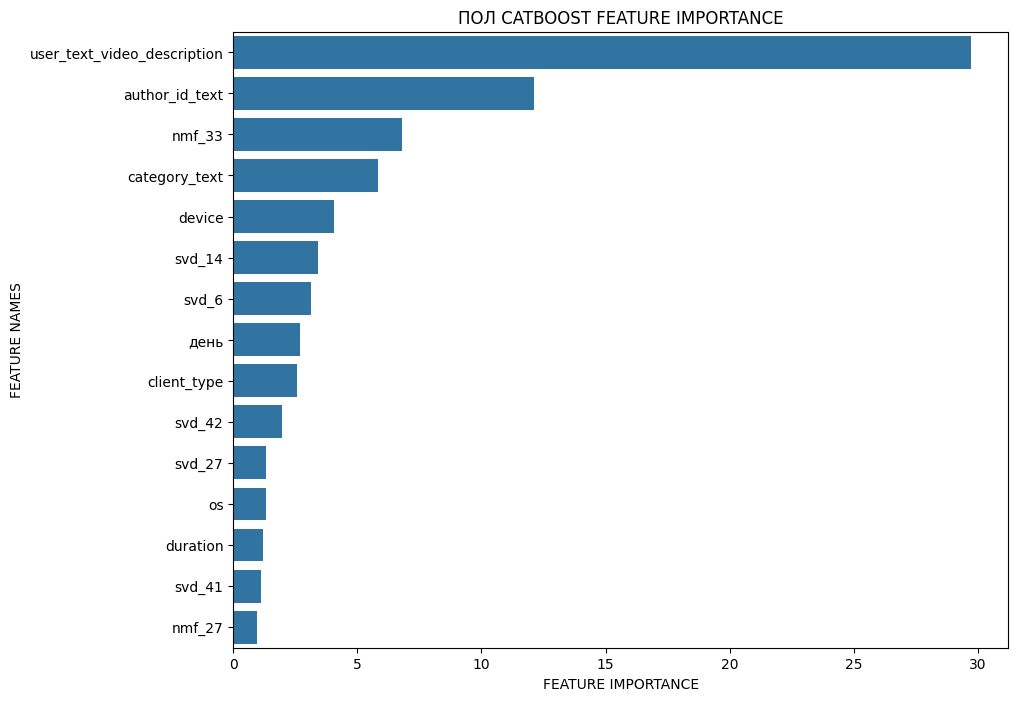

In [56]:
plot_feature_importance(feature_results[:15].importance, feature_results[:15].feature,'ПОЛ CATBOOST')

#### 2.4.2 Топ-15 важных признаков для предсказания возраста

In [57]:
importances = clf_age.feature_importances_
feature_list = list(X.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

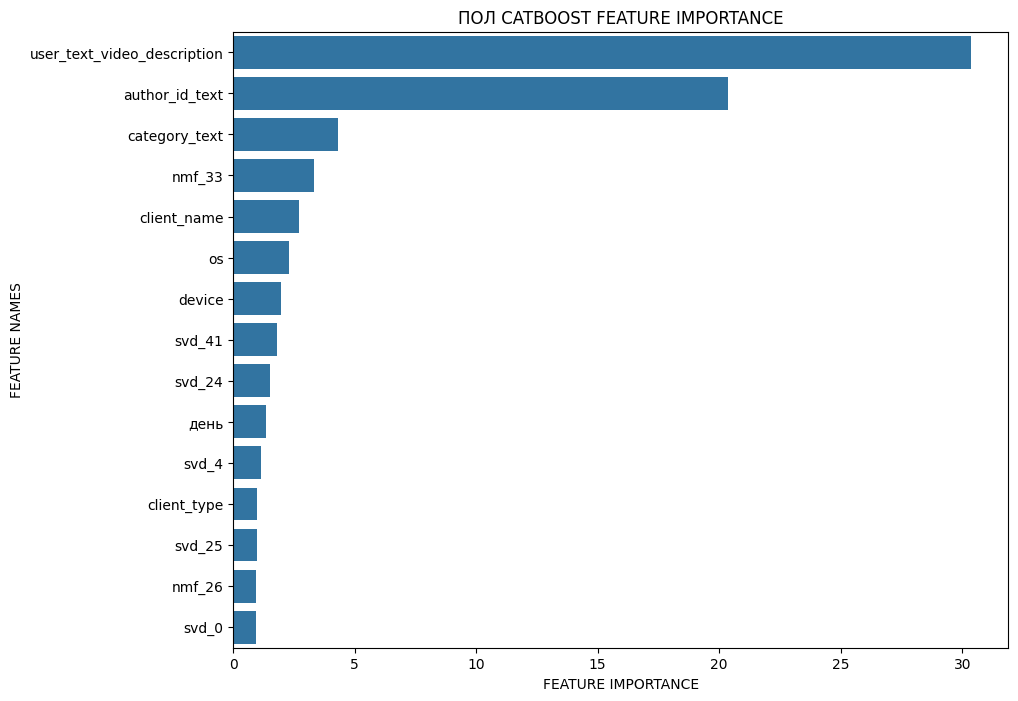

In [58]:
plot_feature_importance(feature_results[:15].importance, feature_results[:15].feature,'ПОЛ CATBOOST')

### 3. Оценка предсказания моделей в зависимости от активности пользователя (количества и общего времени просмотров)

- Будем разделять наши тестовые (валидационные) данные на категории в зависимости от количества просмотров и ощей длительности просмотров, затем посмотрим на метрики. У нас это признаки **video_count** и **duration** 

In [60]:
train_good = train[(train.video_count > 10) | (train.duration > 10)]
train_bad = train[(train.video_count < 10) & (train.duration < 10)]

In [61]:
X_good = train_good.drop(['viewer_uid', 'age', 'sex', 'age_class', ], axis = 1) #'viewer_uid', 
y_sex_good = train_good['sex'].map(lambda x: 1 if str(x) == 'male' else 0)
y_age_good = train_good['age_class']
cat_features = [i for i in X.columns if X.dtypes[i] == 'category']
text_features=[i for i in X.columns if X.dtypes[i] == 'object']
print(f'cat_features', cat_features)
print(f'text_features', text_features)

cat_features ['region', 'device', 'client_type', 'os', 'client_name']
text_features ['user_text_video_description', 'category_text', 'author_id_text']


In [62]:
X_bad = train_bad.drop(['viewer_uid', 'age', 'sex', 'age_class', ], axis = 1) #'viewer_uid', 
y_sex_bad = train_bad['sex'].map(lambda x: 1 if str(x) == 'male' else 0)
y_age_bad = train_bad['age_class']
cat_features = [i for i in X.columns if X.dtypes[i] == 'category']
text_features=[i for i in X.columns if X.dtypes[i] == 'object']
print(f'cat_features', cat_features)
print(f'text_features', text_features)

cat_features ['region', 'device', 'client_type', 'os', 'client_name']
text_features ['user_text_video_description', 'category_text', 'author_id_text']


#### 3.1 Сравним метрики по предсказанию ПОЛА

In [63]:
print(f'ROC_AUC по полу {m.roc_auc_score(y_sex_good, clf_sex.predict_proba(X_good)[:,1]):2.5f}')
print(f'Accuracy по полу {m.accuracy_score(y_sex_good.values, clf_sex.predict(X_good)):2.5f}')

ROC_AUC по полу 0.86352
Accuracy по полу 0.78278


In [64]:
print(f'ROC_AUC по полу {m.roc_auc_score(y_sex_bad, clf_sex.predict_proba(X_bad)[:,1]):2.5f}')
print(f'Accuracy по полу {m.accuracy_score(y_sex_bad.values, clf_sex.predict(X_bad)):2.5f}')

ROC_AUC по полу 0.70143
Accuracy по полу 0.69318


#### 3.2 Сравним метрики по предсказанию ВОЗРАСТА

In [65]:
y_pred_good = clf_age.predict(X_good).reshape(-1)
print(m.classification_report(y_age_good, y_pred_good, target_names = ['9-20 лет','21-30 лет', '31-40 лет', '41-60 лет'])) #, target_names = ['9-20','21-30', '31-40', '41-60']
print(f"f1-weighted: {m.f1_score(y_age_good, y_pred_good, average='weighted'):.5f}")

              precision    recall  f1-score   support

    9-20 лет       0.66      0.01      0.02      6272
   21-30 лет       0.53      0.67      0.59     51643
   31-40 лет       0.49      0.42      0.45     52656
   41-60 лет       0.53      0.53      0.53     35321

    accuracy                           0.52    145892
   macro avg       0.55      0.41      0.40    145892
weighted avg       0.52      0.52      0.50    145892

f1-weighted: 0.50094


In [66]:
y_pred_bad = clf_age.predict(X_bad).reshape(-1)
print(m.classification_report(y_age_bad, y_pred_bad, target_names = ['9-20 лет','21-30 лет', '31-40 лет', '41-60 лет'])) #, target_names = ['9-20','21-30', '31-40', '41-60']
print(f"f1-weighted: {m.f1_score(y_age_bad, y_pred_bad, average='weighted'):.5f}")

              precision    recall  f1-score   support

    9-20 лет       0.83      0.00      0.01      1316
   21-30 лет       0.51      0.46      0.48     11464
   31-40 лет       0.46      0.39      0.42     12920
   41-60 лет       0.47      0.73      0.58      8352

    accuracy                           0.48     34052
   macro avg       0.57      0.39      0.37     34052
weighted avg       0.49      0.48      0.46     34052

f1-weighted: 0.46227


#### В результате исследований мы пришли к выводу, что пользователи, которые просмотрели менее 10 видео, а также общая длительность просмотра видео у которых менее 10 минут плохо поддаются определению поло-возрастных характеристик.

### 4. Обучение моделей на всех данных, по которым имеются таргеты

In [67]:
X = train.drop(['viewer_uid', 'age', 'sex', 'age_class', ], axis = 1) #'viewer_uid', 
y_sex = train['sex'].map(lambda x: 1 if str(x) == 'male' else 0)
y_age = train['age_class']

In [68]:
train_pool_sex_deploy = Pool(
        X, 
        y_sex, 
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train)
    )

In [69]:
%%time
clf_sex_deploy = CatBoostClassifier(random_state=42,
                             task_type='GPU',
                             learning_rate=0.001,
                             iterations=15000,
                             cat_features=cat_features,
                             text_features=text_features,
                             eval_metric='Accuracy') # 'AUC', 'F1'
clf_sex_deploy.fit(train_pool_sex, verbose=500, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7439466	total: 19.6ms	remaining: 4m 53s
500:	learn: 0.7466617	total: 9.09s	remaining: 4m 22s
1000:	learn: 0.7482657	total: 18.3s	remaining: 4m 16s
1500:	learn: 0.7497448	total: 28s	remaining: 4m 11s
2000:	learn: 0.7505711	total: 37.6s	remaining: 4m 4s
2500:	learn: 0.7516475	total: 47.5s	remaining: 3m 57s
3000:	learn: 0.7529668	total: 57.6s	remaining: 3m 50s
3500:	learn: 0.7538279	total: 1m 7s	remaining: 3m 41s
4000:	learn: 0.7546126	total: 1m 16s	remaining: 3m 31s
4500:	learn: 0.7551334	total: 1m 26s	remaining: 3m 20s
5000:	learn: 0.7556125	total: 1m 35s	remaining: 3m 10s
5500:	learn: 0.7561611	total: 1m 44s	remaining: 2m 59s
6000:	learn: 0.7566749	total: 1m 53s	remaining: 2m 49s
6500:	learn: 0.7573346	total: 2m 2s	remaining: 2m 39s
7000:	learn: 0.7578415	total: 2m 10s	remaining: 2m 29s
7500:	learn: 0.7581679	total: 2m 19s	remaining: 2m 19s
8000:	learn: 0.7586609	total: 2m 28s	remaining: 2m 9s
8500:	learn: 0.7592025	total: 2m 37s	remaining: 2m
9000:	learn: 0.7596470	total: 

In [70]:
clf_sex_deploy.save_model(os.path.join(root, 'clf_sex_deploy.cbm'), format="cbm")

In [71]:
train_pool_age_deploy = Pool(
        X, 
        y_age, 
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train)
    )

In [72]:
%%time
clf_age_deploy = CatBoostClassifier(random_state=42,
                             task_type='GPU',
                             learning_rate=0.001,
                             iterations=20000,
                             bagging_temperature=0,
                             loss_function='MultiClass',
                             cat_features=cat_features,
                             text_features=text_features,
                             eval_metric='TotalF1') 
clf_age_deploy.fit(train_pool_age_deploy, verbose=500, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4331832	total: 45.7ms	remaining: 15m 14s
500:	learn: 0.4421281	total: 17.9s	remaining: 11m 37s
1000:	learn: 0.4472822	total: 35.6s	remaining: 11m 15s
1500:	learn: 0.4514705	total: 52.8s	remaining: 10m 50s
2000:	learn: 0.4552834	total: 1m 9s	remaining: 10m 26s
2500:	learn: 0.4586026	total: 1m 25s	remaining: 9m 59s
3000:	learn: 0.4609447	total: 1m 40s	remaining: 9m 28s
3500:	learn: 0.4628091	total: 1m 53s	remaining: 8m 54s
4000:	learn: 0.4642468	total: 2m 6s	remaining: 8m 25s
4500:	learn: 0.4662760	total: 2m 19s	remaining: 8m 1s
5000:	learn: 0.4678845	total: 2m 33s	remaining: 7m 40s
5500:	learn: 0.4685695	total: 2m 46s	remaining: 7m 18s
6000:	learn: 0.4692860	total: 2m 58s	remaining: 6m 56s
6500:	learn: 0.4703024	total: 3m 10s	remaining: 6m 36s
7000:	learn: 0.4714300	total: 3m 23s	remaining: 6m 17s
7500:	learn: 0.4722710	total: 3m 35s	remaining: 5m 59s
8000:	learn: 0.4730077	total: 3m 47s	remaining: 5m 41s
8500:	learn: 0.4737165	total: 4m	remaining: 5m 24s
9000:	learn: 0.4744

In [73]:
clf_age_deploy.save_model(os.path.join(root, 'clf_age_deploy.cbm'), format="cbm")

### 5. Подготовка данных для предсказания

#### 5.1 Соберём все данные (включая новые для предсказания) о просмотрах пользователей в один датафрейм, используем длительность просмотра видео и общую его продолжительность для определения рейтинга видео по пользователю, затем сохраним данные в файл parquet, для дальнейшей аггрегации методами этой библиотеки

In [74]:
%%time
all_events = pd.read_csv(os.path.join(root, 'all_events.csv'))
train_events = pd.read_csv(os.path.join(root, 'train_events.csv'))
test_events = pd.read_csv(os.path.join(root, 'test_events.csv')) # после получения теста
all_video_history = pd.concat([train_events, all_events]) # добавить test_events после получения теста
video_info_v2 = pd.read_csv(os.path.join(root, 'video_info_v2.csv'))
all_video_history = all_video_history[['viewer_uid', 'rutube_video_id', 'total_watchtime']]
all_video_history = all_video_history.merge(video_info_v2[['rutube_video_id', 'duration']], how = 'inner', on = ['rutube_video_id'])
all_video_history['reiting_video'] = all_video_history.total_watchtime * 1000 / all_video_history.duration
all_video_history.to_parquet(os.path.join(root, 'all_video_history_test.pqt'), engine='pyarrow')
data = pq.read_table(os.path.join(root, 'all_video_history_test.pqt'))
pd.DataFrame([(z.name, z.type) for z in data.schema], columns = [['field', 'type']])

CPU times: user 22.2 s, sys: 2.97 s, total: 25.2 s
Wall time: 23.8 s


,field,type
0,viewer_uid,int64
1,rutube_video_id,string
2,total_watchtime,int64
3,duration,int64
4,reiting_video,double


#### 5.2 Соберём матрицу Users-Items с учётом новых данных для предсказания, факторизуем её теми же методами, как и для обучения, чтобы получить эмбеддинги пользователй для предсказания 

In [75]:
%%time
data_agg = data.select(['viewer_uid', 'rutube_video_id', 'reiting_video']).\
    group_by(['viewer_uid', 'rutube_video_id']).aggregate([('reiting_video', 'sum')])
video_set = set(data_agg.select(['rutube_video_id']).to_pandas()['rutube_video_id'])
print(f'{len(video_set)} urls')
video_dict = {video: rutube_video_id for video, rutube_video_id in zip(video_set, range(len(video_set)))}
rev_video_dict = {v: k for k, v in video_dict.items()}
user_set = set(data_agg.select(['viewer_uid']).to_pandas()['viewer_uid'])
print(f'{len(user_set)} users')
user_dict = {user: user_id for user, user_id in zip(user_set, range(len(user_set)))}
rev_user_dict = {v: k for k, v in user_dict.items()}

values = np.array(data_agg.select(['reiting_video_sum']).to_pandas()['reiting_video_sum'])
rows = np.array(data_agg.select(['viewer_uid']).to_pandas()['viewer_uid'].map(user_dict))
cols = np.array(data_agg.select(['rutube_video_id']).to_pandas()['rutube_video_id'].map(video_dict))
mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
mat

354367 urls
1140897 users
CPU times: user 13.4 s, sys: 2.32 s, total: 15.7 s
Wall time: 10.8 s


<COOrdinate sparse matrix of dtype 'float64'
	with 9235390 stored elements and shape (1140897, 354367)>

In [76]:
%%time
from sklearn.decomposition import TruncatedSVD
with open(os.path.join(root, 'svd.fct'), 'rb') as fp:
    svd = pickle.load(fp)
    W = svd.transform(mat)
    usr_emb_svd = pd.DataFrame(W).reset_index()
    usr_emb_svd.columns = ['viewer_uid'] + [f'svd_{i}' for i in usr_emb_svd.columns[1:]]
    usr_emb_svd.viewer_uid = usr_emb_svd.viewer_uid.map(rev_user_dict)
    usr_emb_svd.to_parquet(os.path.join(root, 'usr_emb_svd_test.pqt'), engine='pyarrow')
usr_emb_svd

CPU times: user 4.31 s, sys: 1.39 s, total: 5.7 s
Wall time: 5.21 s


,viewer_uid,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,...,svd_40,svd_41,svd_42,svd_43,svd_44,svd_45,svd_46,svd_47,svd_48,svd_49
0,10485760,3.877389e-13,2.664938e-16,2.062957e-15,7.515695e-14,5.584158e-10,-1.891777e-10,5.626213e-13,7.636568e-13,-1.785375e-09,...,-1.771761e-09,4.982606e-14,-1.136330e-10,-5.497025e-08,-8.671784e-10,-2.011531e-10,5.173188e-09,-3.734568e-09,-1.314650e-08,-8.750702e-09
1,10485761,8.555171e-07,2.075216e-06,1.179728e-04,4.834442e-06,2.333772e-01,-3.819264e-01,1.857030e-05,-1.814688e-04,7.202356e-02,...,-3.796107e-05,-2.022894e-08,3.103471e-05,-1.142282e-02,-2.309413e-05,-5.027943e-05,-1.944971e-01,-5.776909e-02,-7.357631e-03,4.321732e-04
2,10485762,1.020363e-07,1.357560e-07,6.561109e-06,6.195810e-06,8.092373e-02,4.146597e-02,-1.613059e-05,8.874154e-05,-9.751146e-02,...,-5.022699e-06,4.036355e-11,-9.686534e-06,3.626861e-03,5.136412e-03,1.672951e-06,-3.134688e-04,-7.834319e-05,1.648562e-03,-1.388444e-05
3,10485763,1.120580e-05,5.529557e-08,1.526840e-08,4.229645e-08,9.583920e-04,-2.219592e-04,5.053229e-07,6.606727e-07,-1.196096e-03,...,-1.945433e-04,4.969667e-09,-1.342972e-05,-5.717304e-03,2.363258e-04,-2.154346e-05,2.890870e-04,2.894796e-04,-1.316538e-03,-6.849548e-04
4,10485764,3.384224e-14,9.112795e-14,4.522878e-12,4.735490e-11,5.782915e-07,6.962267e-08,7.415572e-10,2.424739e-09,-2.351705e-06,...,-9.144800e-09,-4.156025e-14,-4.364523e-08,1.645474e-05,-9.268723e-06,-6.098364e-09,1.072871e-06,-1.350501e-07,8.984757e-07,7.171723e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140892,10485755,9.177914e-09,1.173751e-08,4.564512e-07,1.399248e-06,3.580514e-03,-8.499105e-05,2.578762e-07,2.103057e-06,-4.399150e-03,...,-5.190139e-06,-3.111289e-10,-1.078627e-05,5.512893e-03,-2.726912e-03,-4.592851e-06,-4.134380e-04,-1.594423e-05,3.072062e-04,-7.945213e-05
1140893,10485756,2.790599e-08,1.384679e-11,3.706693e-08,5.974977e-09,1.732841e-04,-7.483165e-05,-1.165597e-09,-2.272085e-08,-1.104918e-04,...,-6.659357e-08,-1.682366e-11,-3.108331e-08,4.796231e-05,-1.550409e-06,-7.722965e-09,-1.650770e-04,1.224608e-05,1.001692e-05,1.299983e-06
1140894,10485757,2.725509e-13,1.735234e-13,4.686064e-11,5.629834e-11,1.692003e-06,-1.789758e-06,4.511191e-10,7.299259e-09,-1.883171e-06,...,-5.574291e-09,-4.420392e-13,2.597578e-08,-1.027568e-05,3.041590e-06,-8.408676e-10,7.476939e-06,-3.602780e-07,-2.209169e-06,1.192086e-06
1140895,10485758,7.184658e-09,2.431462e-10,7.390062e-07,2.811443e-06,3.235750e-03,-2.154067e-03,-1.746333e-07,-1.015565e-07,-1.099262e-03,...,-1.487315e-06,-1.053216e-09,-4.131560e-06,1.359480e-03,-1.217215e-04,-2.856163e-06,-5.035244e-03,2.101040e-04,1.622271e-03,-7.936926e-05


In [77]:
%%time
from sklearn.decomposition import NMF
with open(os.path.join(root, 'nmf.fct'), 'rb') as fp:
    nmf = pickle.load(fp)
    W = nmf.transform(mat)
    usr_emb_nmf = pd.DataFrame(W).reset_index()
    usr_emb_nmf.columns = ['viewer_uid'] + [f'nmf_{i}' for i in usr_emb_nmf.columns[1:]]
    usr_emb_nmf.viewer_uid = usr_emb_nmf.viewer_uid.map(rev_user_dict)
    usr_emb_nmf.to_parquet(os.path.join(root, 'usr_emb_nmf_test.pqt'), engine='pyarrow')
usr_emb_nmf

violation: 1.0
violation: 0.033670903702841724
violation: 0.003785999910653663
violation: 0.00047724988150786584
violation: 5.82254594150542e-05
Converged at iteration 6
CPU times: user 30.4 s, sys: 2.39 s, total: 32.8 s
Wall time: 32.3 s


,viewer_uid,nmf_0,nmf_1,nmf_2,nmf_3,nmf_4,nmf_5,nmf_6,nmf_7,nmf_8,...,nmf_40,nmf_41,nmf_42,nmf_43,nmf_44,nmf_45,nmf_46,nmf_47,nmf_48,nmf_49
0,10485760,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,10485761,0.0,1.961581e-08,0.000000e+00,0.000000e+00,0.000000e+00,9.459497e-03,3.679602e-07,0.0,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,1.551889e-02,0.000000e+00,0.000000e+00,0.000000e+00
2,10485762,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,8.718391e-03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,10485763,0.0,4.414650e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000e+00,3.800133e-05,0.000000e+00,0.000000e+00
4,10485764,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,...,0.000000e+00,0.000000e+00,2.029502e-11,1.099417e-06,0.000000,0.0,0.000000e+00,0.000000e+00,5.933362e-09,1.297741e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140892,10485755,0.0,0.000000e+00,7.560201e-11,2.279807e-08,5.607880e-06,7.452077e-06,0.000000e+00,0.0,1.093139e-05,...,0.000000e+00,0.000000e+00,2.905753e-07,5.992793e-04,0.000097,0.0,6.406967e-05,1.446478e-05,0.000000e+00,1.046286e-06
1140893,10485756,0.0,0.000000e+00,0.000000e+00,0.000000e+00,3.920595e-07,9.490534e-06,0.000000e+00,0.0,1.332756e-07,...,6.244077e-09,1.374863e-12,6.481157e-09,7.347231e-06,0.000005,0.0,0.000000e+00,1.127036e-06,0.000000e+00,2.744596e-07
1140894,10485757,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,4.769493e-07,0.000000e+00,0.000000e+00,1.015567e-07
1140895,10485758,0.0,0.000000e+00,0.000000e+00,8.437349e-08,1.016292e-05,2.379776e-04,0.000000e+00,0.0,1.881827e-05,...,0.000000e+00,0.000000e+00,0.000000e+00,1.083598e-04,0.000043,0.0,0.000000e+00,1.416344e-05,5.984742e-05,6.016283e-06


#### 5.3 Соберём по пользователю в список все просмотренные им видео, используя файл с информацией о видео сформируем обработанный текст с описаниями всех видео

In [78]:
def user_text_video_description(lst):
    '''функция обрабатывает список из текстов, убирает ненужные символы и короткие слова'''
    return ' '.join([' '.join([''.join(e for e in j if e.isalnum()) for j in dict_video_descriptions[i].lower().split() if len(j) > 1]) for i in lst])

In [79]:
%%time
video_info_v2 = pd.read_csv(os.path.join(root, 'video_info_v2.csv'))
user_video_list = test_events.groupby('viewer_uid')['rutube_video_id'].agg(list).reset_index()
user_video_list.columns = ['viewer_uid', 'video_list']
user_video_list.video_list = user_video_list.video_list.map(lambda x: pd.Series(x).value_counts().index.tolist())
dict_video_descriptions = pd.Series(video_info_v2.title.values, index=video_info_v2.rutube_video_id).to_dict()
user_video_list['user_text_video_description'] = user_video_list.video_list.map(user_text_video_description)
user_video_text = user_video_list.drop(['video_list'], axis=1)
user_video_text.to_parquet(os.path.join(root, 'user_video_text_test.pqt'), engine='pyarrow')
user_video_text

CPU times: user 5.06 s, sys: 57.9 ms, total: 5.12 s
Wall time: 5.12 s


,viewer_uid,user_text_video_description
0,10000003,тьма сезон серия смотреть бесплатно
1,10001128,сообщество сезон серия паранормальное отцовств...
2,10001559,сергей караганов америка идет серии кризисов п...
3,10002319,памяти анастасии заворотнюк здоровье маргариты...
4,10002723,последний герой русский сезон выпуск сокровища...
...,...,...
10203,11140842,годзилла конг новая империя фильм 2024
10204,11140844,люпен сезон серия
10205,11140876,готэм сезон серия
10206,11140877,звёздные войны эпизод империя наносит ответный...


### 5.4 Соберём по пользователю в список все просмотренные им видео, используя файл с информацией о видео сформируем обработанные текст с категориями видео b авторами видео

In [80]:
%%time
video_info_v2 = pd.read_csv(os.path.join(root, 'video_info_v2.csv'))
user_video_list = test_events.groupby('viewer_uid')['rutube_video_id'].agg(list).reset_index()
user_video_list.columns = ['viewer_uid', 'category_list']
user_video_list.category_list = user_video_list.category_list.map(lambda x: pd.Series(x).value_counts().index.tolist())
dict_video_category = pd.Series(video_info_v2.category.values, index=video_info_v2.rutube_video_id).to_dict()
user_video_list['category_text'] = user_video_list.category_list.map(lambda x: ' '.join(dict_video_category[i] for i in x))
user_video_category = user_video_list.drop(['category_list'], axis=1)
user_video_category.to_parquet(os.path.join(root, 'user_video_category_test.pqt'), engine='pyarrow')
user_video_category

CPU times: user 4.79 s, sys: 19.1 ms, total: 4.81 s
Wall time: 4.8 s


,viewer_uid,category_text
0,10000003,Сериалы
1,10001128,Сериалы Сериалы Юмор Сериалы Сериалы Юмор
2,10001559,Разное
3,10002319,Телепередачи
4,10002723,Телепередачи Телепередачи
...,...,...
10203,11140842,Фильмы
10204,11140844,Сериалы
10205,11140876,Сериалы
10206,11140877,Фильмы


In [81]:
%%time
video_info_v2 = pd.read_csv(os.path.join(root, 'video_info_v2.csv'))
user_video_list = test_events.groupby('viewer_uid')['rutube_video_id'].agg(list).reset_index()
user_video_list.columns = ['viewer_uid', 'author_id_list']
user_video_list.author_id_list = user_video_list.author_id_list.map(lambda x: pd.Series(x).value_counts().index.tolist())
dict_video_author_id = pd.Series(video_info_v2.author_id.values, index=video_info_v2.rutube_video_id).to_dict()
user_video_list['author_id_text'] = user_video_list['author_id_list'].map(lambda x: ' '.join(str(dict_video_author_id[i]) for i in x))
user_video_author_id = user_video_list.drop(['author_id_list'], axis=1)
user_video_author_id.to_parquet(os.path.join(root, 'user_video_author_id_test.pqt'), engine='pyarrow')
user_video_author_id

CPU times: user 4.37 s, sys: 31.5 ms, total: 4.4 s
Wall time: 4.39 s


,viewer_uid,author_id_text
0,10000003,1036141
1,10001128,1043618 1043618 1006760 1043618 1043618 1006760
2,10001559,1009168
3,10002319,1008828
4,10002723,1002137 1009257
...,...,...
10203,11140842,1043618
10204,11140844,1036271
10205,11140876,1058110
10206,11140877,1001198


### 5.5 Соберём по пользователю признаки - количество просмотренных видео и общая продолжительность просмотренных видео в часах

In [82]:
user_video_count = test_events.groupby('viewer_uid')['rutube_video_id'].agg('count').reset_index()
user_video_count.columns = ['viewer_uid', 'video_count']
user_video_duration = test_events.groupby('viewer_uid')['total_watchtime'].agg(sum).reset_index()
user_video_duration.columns = ['viewer_uid', 'duration']
user_video_duration.duration = user_video_duration.duration / 60
user_video_count = user_video_count.merge(user_video_duration, how = 'inner', on = ['viewer_uid'])
user_video_count

,viewer_uid,video_count,duration
0,10000003,1,31.550000
1,10001128,6,91.450000
2,10001559,1,74.533333
3,10002319,1,7.516667
4,10002723,2,29.983333
...,...,...,...
10203,11140842,1,15.250000
10204,11140844,1,48.550000
10205,11140876,1,17.283333
10206,11140877,1,20.000000


### 5.6 Соберём по пользователю признаки регон, устройство, браузер, операционная система, название браузера по последнему просмотру видео, соединим их в один датафрейм с признаком из предыдщего пункта и сохраним для дальнейшего использования

In [83]:
user_region = test_events.groupby('viewer_uid')['region'].agg('last').reset_index()
user_region.columns = ['viewer_uid', 'region']
user_device = test_events.groupby('viewer_uid')['ua_device_type'].agg('last').reset_index()
user_device.columns = ['viewer_uid', 'device']
user_client_type = test_events.groupby('viewer_uid')['ua_client_type'].agg('last').reset_index()
user_client_type.columns = ['viewer_uid', 'client_type']
user_os = test_events.groupby('viewer_uid')['ua_os'].agg('last').reset_index()
user_os.columns = ['viewer_uid', 'os']
user_client_name = test_events.groupby('viewer_uid')['ua_client_name'].agg('last').reset_index()
user_client_name.columns = ['viewer_uid', 'client_name']

user_cat_features_1 = user_video_count.merge(user_region, how = 'inner', on = ['viewer_uid'])
user_cat_features_1 = user_cat_features_1.merge(user_device, how = 'inner', on = ['viewer_uid'])
user_cat_features_1 = user_cat_features_1.merge(user_client_type, how = 'inner', on = ['viewer_uid'])
user_cat_features_1 = user_cat_features_1.merge(user_os, how = 'inner', on = ['viewer_uid'])
user_cat_features_1 = user_cat_features_1.merge(user_client_name, how = 'inner', on = ['viewer_uid'])
user_cat_features_1.to_parquet(os.path.join(root, 'user_cat_features_1_test.pqt'), engine='pyarrow')
user_cat_features_1

,viewer_uid,video_count,duration,region,device,client_type,os,client_name
0,10000003,1,31.550000,Moscow Oblast,desktop,browser,Windows,Opera
1,10001128,6,91.450000,Chelyabinsk,smartphone,mobile app,Android,Rutube
2,10001559,1,74.533333,Chelyabinsk,smartphone,mobile app,Android,Rutube
3,10002319,1,7.516667,Stavropol Kray,desktop,browser,Windows,Yandex Browser
4,10002723,2,29.983333,Moscow,smartphone,mobile app,Android,Rutube
...,...,...,...,...,...,...,...,...
10203,11140842,1,15.250000,Moscow,smartphone,mobile app,Android,Rutube
10204,11140844,1,48.550000,Tula Oblast,smartphone,mobile app,Android,Rutube
10205,11140876,1,17.283333,Moscow Oblast,tablet,mobile app,Android,Rutube
10206,11140877,1,20.000000,Vologda Oblast,smartphone,mobile app,Android,Rutube


### 5.7 Сформируем дополнительные признаки для предсказания модели используя метку времени просмотра

In [84]:
test_events = pd.read_csv(os.path.join(root, 'test_events.csv'))
test_events["event_timestamp"] = pd.to_datetime(test_events["event_timestamp"])
region_tz = pd.read_csv(os.path.join(root, 'region_tz.csv'))
test_events = test_events.merge(region_tz, left_on="region", right_on="Регион en")

In [85]:
def get_utc_tz(tz: str) -> int:
    """ получение часовой метки временной зоны

    Args:
        tz (str): временная зона

    Returns:
        int: часовая метка
    """

    return int(tz[3:])

In [86]:
test_events["timezone"] = test_events["timezone"].map(get_utc_tz)
test_events["gmt diff"] = test_events["timezone"] - 3

In [87]:
# получение регионального времени
current_event_time = []
# проход в цикле по дате события и разницы во времени относительно GMT + 3
for event_time, gmt_diff in test_events.iloc[:,[0, -1]].values:
    # разница во времени
    delta = datetime.timedelta(hours=gmt_diff)
    # получение регионально времени в зависимости от разницы во времени
    if gmt_diff < 0:
        current_event_time.append(event_time - delta)
    elif gmt_diff > 0:
        current_event_time.append(event_time + delta)
    else:
        current_event_time.append(event_time)

In [88]:
test_events["current_event_time"] = current_event_time

In [89]:
del current_event_time

In [90]:
# временной диапазон
test_events["current_event_time"].agg(["min", "max"])

min   2024-06-30 00:00:04+03:00
max   2024-07-01 08:38:41+03:00
Name: current_event_time, dtype: datetime64[ns, UTC+03:00]

In [91]:
# региональное время
test_events["current_time"] = test_events["current_event_time"].dt.time

In [92]:
# временные диапазоны времени суток
cut_labels = ["ночь", "утро", "день", "вечер"]
cut_bins = [datetime.time.fromisoformat("00:00:00"),
            datetime.time.fromisoformat("06:00:00"),
            datetime.time.fromisoformat("12:00:00"),
            datetime.time.fromisoformat("18:00:00"),
            datetime.time.fromisoformat("23:59:59")]

In [93]:
# временные диапазоны времени суток
test_events["time_cut"] = pd.cut(test_events["current_time"], bins=cut_bins, labels=cut_labels)

In [94]:
#  признак дня недели
test_events["current_weekday"] = test_events["current_event_time"].dt.weekday

In [95]:
def is_day_off(weekday: int) -> bool:
    """проверяет - является ли день просмотра выходным днём

    Args:
        weekday (int): день недели

    Returns:
        bool: является ли день просмотра выходным днём
    """
    return weekday in [5, 6]

In [96]:
#  признак выходного дня недели
test_events["is_day_off"] = test_events["current_weekday"].map(is_day_off) 

In [97]:
test_events_time = test_events[['viewer_uid', 'lat', 'lon', 'time_cut', 'current_weekday', 'is_day_off']]

In [98]:
test_events_time

,viewer_uid,lat,lon,time_cut,current_weekday,is_day_off
0,10317890,43.1156,131.8851,утро,6,True
1,10546804,56.0153,92.8932,день,6,True
2,10670379,56.3269,44.0059,ночь,6,True
3,11028571,55.7558,37.6173,ночь,6,True
4,10432484,56.3269,44.0059,ночь,6,True
...,...,...,...,...,...,...
19995,10687999,56.3269,44.0059,вечер,6,True
19996,10425804,55.1644,61.4368,утро,6,True
19997,10565147,45.0355,38.9753,утро,6,True
19998,10715847,55.7558,37.6173,вечер,6,True


In [99]:
test_events_lat = test_events_time.groupby('viewer_uid')['lat'].agg('last').reset_index()
test_events_lon = test_events_time.groupby('viewer_uid')['lon'].agg('last').reset_index()
test_events_fichi_time = test_events_lat.merge(test_events_lon, how = 'left', on = ['viewer_uid'])

df_temp = test_events_time[test_events_time['time_cut'] == 'ночь'].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
df_temp.columns = ['viewer_uid', 'ночь']
test_events_fichi_time = test_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])

df_temp = test_events_time[test_events_time['time_cut'] == 'утро'].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
df_temp.columns = ['viewer_uid', 'утро']
test_events_fichi_time = test_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])

df_temp = test_events_time[test_events_time['time_cut'] == 'день'].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
df_temp.columns = ['viewer_uid', 'день']
test_events_fichi_time = test_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])

df_temp = test_events_time[test_events_time['time_cut'] == 'вечер'].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
df_temp.columns = ['viewer_uid', 'вечер']
test_events_fichi_time = test_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])


for i in range(7):
    df_temp = test_events_time[test_events_time['current_weekday'] == i].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
    df_temp.columns = ['viewer_uid', f'{i}-день']
    test_events_fichi_time = test_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])
    
df_temp = test_events_time[test_events_time['is_day_off'] == True].groupby('viewer_uid')['time_cut'].agg('count').reset_index()
df_temp.columns = ['viewer_uid', f'выходной день']
test_events_fichi_time = test_events_fichi_time.merge(df_temp, how = 'left', on = ['viewer_uid'])
test_events_fichi_time = test_events_fichi_time.fillna(0)
test_events_fichi_time.to_parquet(os.path.join(root, 'test_events_fichi_time.pqt'), engine='pyarrow')
test_events_fichi_time

,viewer_uid,lat,lon,ночь,утро,день,вечер,0-день,1-день,2-день,3-день,4-день,5-день,6-день,выходной день
0,10000003,55.7558,37.6173,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,10001128,55.1644,61.4368,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0
2,10001559,55.1644,61.4368,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,10002319,45.0443,41.9684,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,10002723,55.7558,37.6173,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10203,11140842,55.7558,37.6173,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
10204,11140844,54.1971,37.6135,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
10205,11140876,55.7558,37.6173,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
10206,11140877,59.2243,39.8910,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


#### 5.8 Используем все файлы и соберём итоговый датасет

In [100]:
usr_emb_svd = pd.read_parquet(os.path.join(root, 'usr_emb_svd_test.pqt'), engine='pyarrow')
usr_emb_nmf = pd.read_parquet(os.path.join(root, 'usr_emb_nmf_test.pqt'), engine='pyarrow')
user_video_text = pd.read_parquet(os.path.join(root, 'user_video_text_test.pqt'), engine='pyarrow')
user_video_category = pd.read_parquet(os.path.join(root, 'user_video_category_test.pqt'), engine='pyarrow')
user_video_author_id = pd.read_parquet(os.path.join(root, 'user_video_author_id_test.pqt'), engine='pyarrow')
user_cat_features_1 = pd.read_parquet(os.path.join(root, 'user_cat_features_1_test.pqt'), engine='pyarrow')
test_events_fichi_time = pd.read_parquet(os.path.join(root, 'test_events_fichi_time.pqt'), engine='pyarrow')
cat_features_1 = ['region',	'device', 'client_type', 'os', 'client_name']
for feature in cat_features_1:
   user_cat_features_1[f'{feature}'] = user_cat_features_1[f'{feature}'].fillna('unknown').astype('category')

In [101]:
test_id = test_events.groupby('viewer_uid')['rutube_video_id'].agg('count').reset_index()[['viewer_uid']]
test_id

,viewer_uid
0,10000003
1,10001128
2,10001559
3,10002319
4,10002723
...,...
10203,11140842
10204,11140844
10205,11140876
10206,11140877


In [102]:
test = test_id.merge(user_video_text, how = 'inner', on = ['viewer_uid'])
test = test.merge(user_video_category, how = 'inner', on = ['viewer_uid'])
test = test.merge(user_video_author_id, how = 'inner', on = ['viewer_uid'])
test = test.merge(usr_emb_svd, how = 'inner', on = ['viewer_uid'])
test = test.merge(usr_emb_nmf, how = 'inner', on = ['viewer_uid'])
test = test.merge(user_cat_features_1, how = 'inner', on = ['viewer_uid'])
test = test.merge(test_events_fichi_time, how = 'inner', on = ['viewer_uid'])
test

,viewer_uid,user_text_video_description,category_text,author_id_text,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,...,день,вечер,0-день,1-день,2-день,3-день,4-день,5-день,6-день,выходной день
0,10000003,тьма сезон серия смотреть бесплатно,Сериалы,1036141,3.578244e-09,7.873595e-12,1.262248e-09,5.314938e-09,1.141890e-04,3.872716e-05,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,10001128,сообщество сезон серия паранормальное отцовств...,Сериалы Сериалы Юмор Сериалы Сериалы Юмор,1043618 1043618 1006760 1043618 1043618 1006760,6.878551e-14,3.034622e-14,1.030912e-12,5.458306e-12,1.154543e-07,1.225470e-08,...,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0
2,10001559,сергей караганов америка идет серии кризисов п...,Разное,1009168,3.767510e-08,3.498525e-12,7.101696e-10,1.547502e-09,3.942109e-05,-1.386947e-05,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,10002319,памяти анастасии заворотнюк здоровье маргариты...,Телепередачи,1008828,5.609919e-08,4.494001e-10,1.826481e-06,3.157006e-06,5.965242e-03,-4.001340e-03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,10002723,последний герой русский сезон выпуск сокровища...,Телепередачи Телепередачи,1002137 1009257,1.473712e-07,3.371324e-07,8.539243e-06,2.247988e-05,1.020409e-01,3.762582e-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10203,11140842,годзилла конг новая империя фильм 2024,Фильмы,1043618,3.081999e-09,1.660467e-08,6.570090e-10,1.791630e-09,4.574953e-05,3.011723e-06,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
10204,11140844,люпен сезон серия,Сериалы,1036271,2.467190e-16,1.465654e-19,1.501671e-16,9.477142e-16,8.660181e-11,-4.955230e-11,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
10205,11140876,готэм сезон серия,Сериалы,1058110,2.339124e-14,1.303326e-13,2.304185e-11,7.129560e-11,2.231232e-06,9.919930e-07,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
10206,11140877,звёздные войны эпизод империя наносит ответный...,Фильмы,1001198,5.729952e-14,8.180302e-14,8.146926e-12,5.923823e-11,1.068001e-06,6.224471e-07,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [103]:
X_test = test.drop(['viewer_uid'], axis = 1)
cat_features = [i for i in X.columns if X.dtypes[i] == 'category']
text_features=[i for i in X.columns if X.dtypes[i] == 'object']
print(f'cat_features', cat_features)
print(f'text_features', text_features)

cat_features ['region', 'device', 'client_type', 'os', 'client_name']
text_features ['user_text_video_description', 'category_text', 'author_id_text']


In [104]:
X_test

,user_text_video_description,category_text,author_id_text,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,...,день,вечер,0-день,1-день,2-день,3-день,4-день,5-день,6-день,выходной день
0,тьма сезон серия смотреть бесплатно,Сериалы,1036141,3.578244e-09,7.873595e-12,1.262248e-09,5.314938e-09,1.141890e-04,3.872716e-05,1.440768e-08,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,сообщество сезон серия паранормальное отцовств...,Сериалы Сериалы Юмор Сериалы Сериалы Юмор,1043618 1043618 1006760 1043618 1043618 1006760,6.878551e-14,3.034622e-14,1.030912e-12,5.458306e-12,1.154543e-07,1.225470e-08,8.091518e-11,...,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0
2,сергей караганов америка идет серии кризисов п...,Разное,1009168,3.767510e-08,3.498525e-12,7.101696e-10,1.547502e-09,3.942109e-05,-1.386947e-05,9.349133e-09,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,памяти анастасии заворотнюк здоровье маргариты...,Телепередачи,1008828,5.609919e-08,4.494001e-10,1.826481e-06,3.157006e-06,5.965242e-03,-4.001340e-03,-3.633410e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,последний герой русский сезон выпуск сокровища...,Телепередачи Телепередачи,1002137 1009257,1.473712e-07,3.371324e-07,8.539243e-06,2.247988e-05,1.020409e-01,3.762582e-02,-1.548233e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10203,годзилла конг новая империя фильм 2024,Фильмы,1043618,3.081999e-09,1.660467e-08,6.570090e-10,1.791630e-09,4.574953e-05,3.011723e-06,9.780750e-09,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
10204,люпен сезон серия,Сериалы,1036271,2.467190e-16,1.465654e-19,1.501671e-16,9.477142e-16,8.660181e-11,-4.955230e-11,2.552511e-11,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
10205,готэм сезон серия,Сериалы,1058110,2.339124e-14,1.303326e-13,2.304185e-11,7.129560e-11,2.231232e-06,9.919930e-07,-9.463025e-10,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
10206,звёздные войны эпизод империя наносит ответный...,Фильмы,1001198,5.729952e-14,8.180302e-14,8.146926e-12,5.923823e-11,1.068001e-06,6.224471e-07,6.549591e-11,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [105]:
set(X.columns) - set(X_test.columns)

set()

### 6. Получение предсказаний и формирование файла для направления в проверяющую систему

In [106]:
from catboost import CatBoostClassifier
model = CatBoostClassifier()

In [107]:
clf_sex_deploy = model.load_model(os.path.join(root, 'clf_sex_deploy.cbm'), format="cbm")

In [108]:
clf_age_deploy = model.load_model(os.path.join(root, 'clf_age_deploy.cbm'), format="cbm")

In [109]:
y_pred_sex = clf_sex_deploy.predict(X_test)

In [110]:
y_pred_age = clf_age_deploy.predict(X_test).reshape(-1)

In [111]:
test_id['sex'] = y_pred_sex
test_id['age_class'] = y_pred_age 
test_id.sex = test_id.sex.map(lambda x: 'male' if x == 1 else 'female')
test_id

,viewer_uid,sex,age_class
0,10000003,male,1
1,10001128,female,3
2,10001559,female,3
3,10002319,female,3
4,10002723,female,2
...,...,...,...
10203,11140842,female,2
10204,11140844,female,2
10205,11140876,female,2
10206,11140877,female,3


In [112]:
test_id.to_csv('data/submission.csv', index=False)